<h1>1. Introduction</h1>

We will be exploring the [TV Shows dataset](https://www.kaggle.com/ruchi798/tv-shows-on-netflix-prime-video-hulu-and-disney) by Ruchi Bhatia. This dataset contain TV show titles, the year it is produced, its target age group, IMDb and Rotten Tomatoes ratings, and which streaming platform they can be found on, ie. Netflix, Hulu, Prime Video, and Disney+.

This Jupyter Notebook will look at which platform has better exclusive shows in terms of ratings. Is there a streaming platform that has way better exclusive shows and is the obvious choice to subscribe to? Or are all the platforms similar and the only way to choose is looking at specific titles that one might be interested in? This is one area of the dataset that we will explore. Another idea is that we will examine is whether IMDb and Rotten Tomatoes ratings are correlated with each other. Are the two sites offering the same opinion? Or are they more varied and have different things to say about each show?

<h2>1.1. Python Libraries and Loading the Data</h2>

To start, we need to import a few libraries. We will use Pandas to store and make changes to our dataset, such as data cleaning and analysis. Then we will use Matplotlob and Seaborn to create visualizations. We will also use linear model from Sklearn to get the line of best fit to annotate our chart.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

Load the downloaded dataset into a Pandas dataframe.

In [2]:
path = "tv_shows.csv"
df = pd.read_csv(path)
df

,Unnamed: 0,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,type
0,0,Breaking Bad,2008,18+,9.5,96%,1,0,0,0,1
1,1,Stranger Things,2016,16+,8.8,93%,1,0,0,0,1
2,2,Money Heist,2017,18+,8.4,91%,1,0,0,0,1
3,3,Sherlock,2010,16+,9.1,78%,1,0,0,0,1
4,4,Better Call Saul,2015,18+,8.7,97%,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
5606,5606,Tut's Treasures: Hidden Secrets,2018,NaN,NaN,NaN,0,0,0,1,1
5607,5607,Paradise Islands,2017,NaN,NaN,NaN,0,0,0,1,1
5608,5608,Wild Russia,2018,NaN,NaN,NaN,0,0,0,1,1
5609,5609,Love & Vets,2017,NaN,NaN,NaN,0,0,0,1,1


<h1>2. Data Cleaning & Pre-processing</h1>

There seems to be columns containing irrelevant information, we can remove them.

In [3]:
df.drop(["Unnamed: 0", "type"], axis = 1, inplace = True)
df

,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+
0,Breaking Bad,2008,18+,9.5,96%,1,0,0,0
1,Stranger Things,2016,16+,8.8,93%,1,0,0,0
2,Money Heist,2017,18+,8.4,91%,1,0,0,0
3,Sherlock,2010,16+,9.1,78%,1,0,0,0
4,Better Call Saul,2015,18+,8.7,97%,1,0,0,0
...,...,...,...,...,...,...,...,...,...
5606,Tut's Treasures: Hidden Secrets,2018,NaN,NaN,NaN,0,0,0,1
5607,Paradise Islands,2017,NaN,NaN,NaN,0,0,0,1
5608,Wild Russia,2018,NaN,NaN,NaN,0,0,0,1
5609,Love & Vets,2017,NaN,NaN,NaN,0,0,0,1


We will remove rows that don't have IMDb and Rotten Tomatoes ratings for our analysis.

In [4]:
df = df.dropna(subset = ["IMDb"])
df = df.dropna(subset = ["Rotten Tomatoes"])
df

,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+
0,Breaking Bad,2008,18+,9.5,96%,1,0,0,0
1,Stranger Things,2016,16+,8.8,93%,1,0,0,0
2,Money Heist,2017,18+,8.4,91%,1,0,0,0
3,Sherlock,2010,16+,9.1,78%,1,0,0,0
4,Better Call Saul,2015,18+,8.7,97%,1,0,0,0
...,...,...,...,...,...,...,...,...,...
5509,Diary of a Future President,2020,7+,5.5,100%,0,0,0,1
5517,Encore!,2019,7+,7.4,68%,0,0,0,1
5522,Spider-Man Unlimited,1999,7+,6.5,50%,0,0,0,1
5530,The Super Hero Squad Show,2009,7+,6.1,50%,0,0,0,1


Looking at the dataset column values, there are percentage signs under Rotten Tomatoes. This column is object type and will cause issues when we calculate the average ratings. Let's change it to numeric type.

In [5]:
# Check datatype of columns
df.dtypes

Title               object
Year                 int64
Age                 object
IMDb               float64
Rotten Tomatoes     object
Netflix              int64
Hulu                 int64
Prime Video          int64
Disney+              int64
dtype: object

In [6]:
# Remove percentage sign from Rotten Tomatoes and convert column to numeric type
df["Rotten Tomatoes"] = df["Rotten Tomatoes"].str.replace("%", "")
df["Rotten Tomatoes"] = pd.to_numeric(df["Rotten Tomatoes"]) 

Since we want to examine platform exclusive shows, we need a way to separate them from shows that appear on multiple platforms.

In [7]:
# Create a new dataframe with only exclusive TV shows as rows
df2 = df.loc[(df["Netflix"] + df["Hulu"] + df["Prime Video"] + df["Disney+"]) == 1].copy()
df2

,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+
0,Breaking Bad,2008,18+,9.5,96,1,0,0,0
1,Stranger Things,2016,16+,8.8,93,1,0,0,0
2,Money Heist,2017,18+,8.4,91,1,0,0,0
3,Sherlock,2010,16+,9.1,78,1,0,0,0
4,Better Call Saul,2015,18+,8.7,97,1,0,0,0
...,...,...,...,...,...,...,...,...,...
5509,Diary of a Future President,2020,7+,5.5,100,0,0,0,1
5517,Encore!,2019,7+,7.4,68,0,0,0,1
5522,Spider-Man Unlimited,1999,7+,6.5,50,0,0,0,1
5530,The Super Hero Squad Show,2009,7+,6.1,50,0,0,0,1


<h1>3. Data Analysis & Visualizations</h1>

<h2>3.1. Examining Exclusive Shows</h2>

Now we calculate the how many exclusive shows are on each platform, and each platform's average IMDb and Rotten Tomatoes ratings.

In [8]:
# Create new dataframe to store those statistics
platforms = ["Netflix", "Hulu", "Prime Video", "Disney+"]
lst = []
for platform in platforms:
    temp = []
    temp.append(platform)
    temp.append(df2[df2[platform] == 1]["Title"].count())
    temp.append(df2[df2[platform] == 1]["IMDb"].mean())
    temp.append(df2[df2[platform] == 1]["Rotten Tomatoes"].mean())
    lst.append(temp)
df3 = pd.DataFrame(lst, columns = ["Platform", "Count", "Average IMDb", "Average Rotten Tomatoes"])
df3

,Platform,Count,Average IMDb,Average Rotten Tomatoes
0,Netflix,419,7.467064,77.725537
1,Hulu,321,7.417757,77.158879
2,Prime Video,187,7.612299,76.283422
3,Disney+,21,7.333333,79.904762


This table shows how many exclusive shows are on each platform, and their average IMDb and Rotten Tomatoes ratings.



<h3>3.1.1. Number of exclusive shows</h3>

Next, we will create a column chart to visualize the number of exclusive shows. 

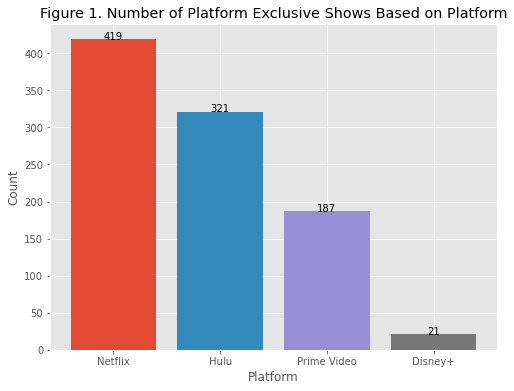

In [9]:
# Using style called ggplot 
plt.style.use(["ggplot"])

# Get colors from style
color = []
for i in range(4):
    color.append(list(plt.rcParams['axes.prop_cycle'])[i]['color'])


# Plot how many exclusive TV shows are on each platform, and each platform's porportion out of all exclusive shows
x = "Platform"
y = "Count"
df3.sort_values(by = [y], ascending=False, inplace = True)

plt.figure(figsize=(8,6))
plt.xlabel(x)
plt.ylabel(y)
for i in range(len(df3[x])):
    plt.text(i,df3[y][i],df3[y][i], ha = "center")
plt.title("Figure 1. Number of Platform Exclusive Shows Based on Platform")
plt.bar(df3[x], df3[y], color = color)
plt.show()

Netflix has the most number of exclusive shows at 419, and Disney has the least at 21. One might expect quantity to be inversely proportional to quality, but that is not exactly the case here. Disney+ has the least exclusive titles, but also the highest average Rotten Tomatoes ratings and lowest average IMDb ratings. Netflox on the other hand with the most number of exclusive titles is in the middle of the pack in terms of both average ratings.

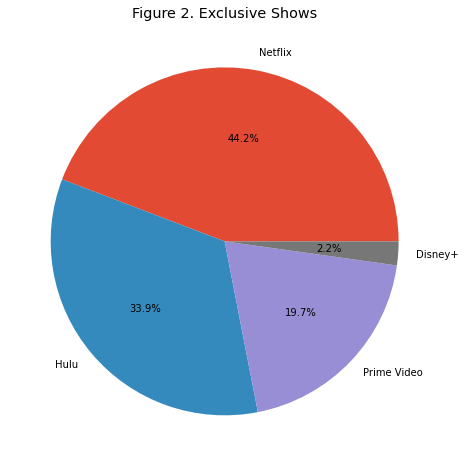

In [10]:
plt.figure(figsize=(10,8))
plt.title("Figure 2. Exclusive Shows")
plt.pie(df3[y], labels = df3[x], autopct = "%1.1f%%")
plt.show() 

Pie chart can also be used to show each platform's proportion in terms of all the exclusive shows.

<h3>3.1.2. Average IMDb rating of platform exclusive TV shows</h3>

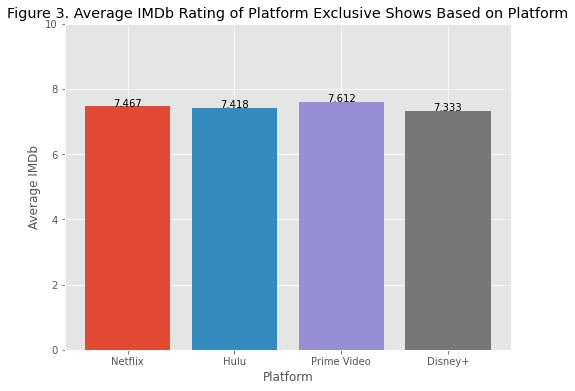

In [11]:
# Plot the average IMDb rating of platform exclusive TV shows
x = "Platform"
y = "Average IMDb"

plt.figure(figsize=(8,6))
plt.xlabel(x)
plt.ylabel(y)
plt.ylim([0, 10])
for i in range(len(df3[x])):
    plt.text(i,df3[y][i],round(df3[y][i], 3), ha = "center")
plt.title("Figure 3. Average IMDb Rating of Platform Exclusive Shows Based on Platform")
plt.bar(df3[x], df3[y], color = color)
plt.show()

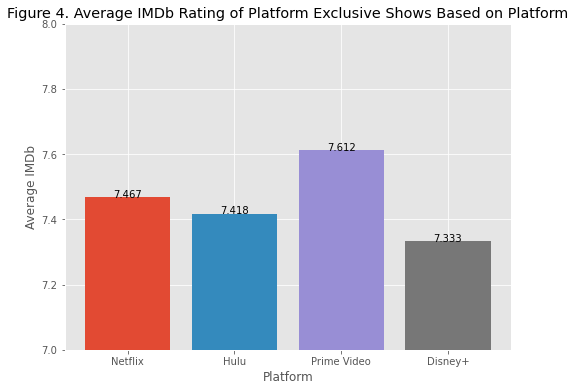

In [12]:
# Shift the axis to better show the difference
x = "Platform"
y = "Average IMDb"

plt.figure(figsize=(8,6))
plt.xlabel(x)
plt.ylabel(y)
plt.ylim([7, 8])
for i in range(len(df3[x])):
    plt.text(i,df3[y][i],round(df3[y][i], 3), ha = "center")
plt.title("Figure 4. Average IMDb Rating of Platform Exclusive Shows Based on Platform")
plt.bar(df3[x], df3[y], color = color)
plt.show()

Prime Video has the highest average IMDb rating, and Disney has the lowest.

<h3>3.1.3. Average Rotten Tomatoes rating of platform exclusive TV shows</h3>

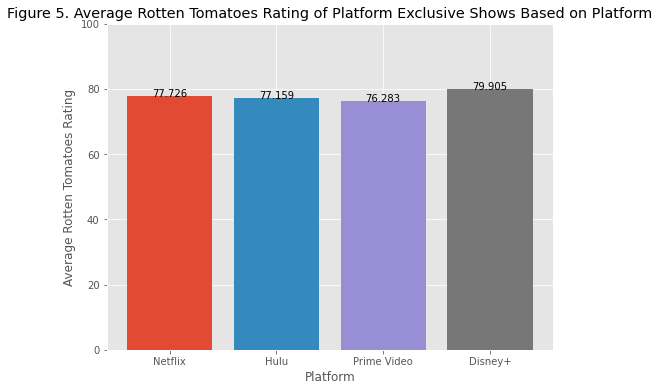

In [13]:
# Plot the average Rotten Tomatoes rating of platform exclusive TV shows
x = "Platform"
y = "Average Rotten Tomatoes"

plt.figure(figsize=(8,6))
plt.xlabel(x)
plt.ylabel("Average Rotten Tomatoes Rating")
plt.ylim([0, 100])
for i in range(len(df3[x])):
    plt.text(i,df3[y][i],round(df3[y][i], 3), ha = "center")
plt.title("Figure 5. Average Rotten Tomatoes Rating of Platform Exclusive Shows Based on Platform")
plt.bar(df3[x], df3[y], color = color)
plt.show()

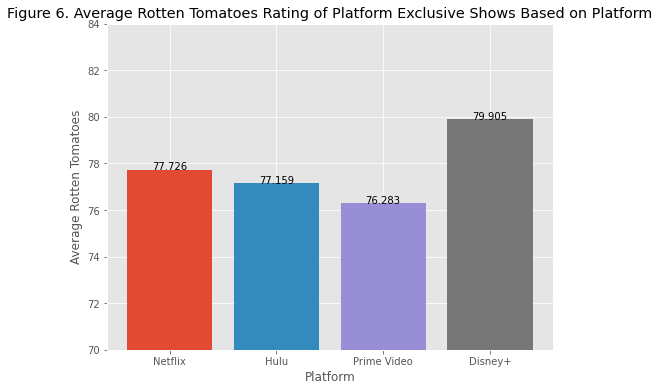

In [14]:
# Shift the axis to better show the difference
x = "Platform"
y = "Average Rotten Tomatoes"

plt.figure(figsize=(8,6))
plt.xlabel(x)
plt.ylabel(y)
plt.ylim([70, 84])
for i in range(len(df3[x])):
    plt.text(i,df3[y][i],round(df3[y][i], 3), ha = "center")
plt.title("Figure 6. Average Rotten Tomatoes Rating of Platform Exclusive Shows Based on Platform")
plt.bar(df3[x], df3[y], color = color)
plt.show()

Disney+ has the highest Average Rotten Tomatoes rating and Prime Video has the lowest.

<h2>3.2. Examining Correlation between IMDb and Rotten Tomatoes</h2>

<h3>3.2.1. Correlation from all TV shows</h3>

We will now look at the correlation between IMDb and Rotten Tomatoes. Going back to our dataset before we separated all the exclusive TV shows.

In [15]:
# Examine the correlation between IMDb and Rotten Tomatoes
df.corr()

,Year,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+
Year,1.000000,-0.227022,-0.064857,0.191534,-0.210033,-0.211939,-0.014959
IMDb,-0.227022,1.000000,0.488869,0.008180,-0.008364,0.083209,-0.009926
Rotten Tomatoes,-0.064857,0.488869,1.000000,0.017376,0.017937,-0.012721,0.028001
Netflix,0.191534,0.008180,0.017376,1.000000,-0.577131,-0.408653,-0.141378
Hulu,-0.210033,-0.008364,0.017937,-0.577131,1.000000,-0.254863,-0.079816
Prime Video,-0.211939,0.083209,-0.012721,-0.408653,-0.254863,1.000000,-0.083718
Disney+,-0.014959,-0.009926,0.028001,-0.141378,-0.079816,-0.083718,1.000000


This table shows the correlation values for each columns within our dataframe. The correlation value between IMDb and Rotten Tomatoes is 0.488869, which indicates a positive correlation, but not a strong one.


We can also plot IMDb vs Rotten Tomatoes on a regression plot, complete with a regression line.

In [16]:
lm = LinearRegression()
lm.fit(df[["IMDb"]], df["Rotten Tomatoes"])

LinearRegression()

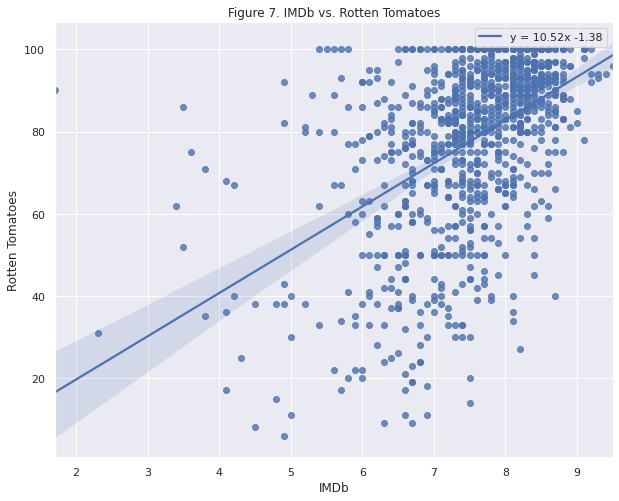

In [17]:
sns.set(rc={"figure.figsize":(10, 8)})
ax = sns.regplot(x = "IMDb", y = "Rotten Tomatoes", data = df, 
                 line_kws={"label":"y = {0:.2f}x {1:.2f}".format(lm.coef_[0],lm.intercept_)})
ax.legend()
ax.set(title = "Figure 7. IMDb vs. Rotten Tomatoes")
plt.show()

Again, there appear to be a positive correlation due to the positive slope, but the dots are scattered on both side of the line so it cannot be a strong correlation.

<h3>3.2.2 Correlation from exclusive TV shows</h3>

We can examine the correlation between IMDb and Rotten Tomatoes for the exclusive shows as well. 

In [18]:
# Examine the correlation between IMDb and Rotten Tomatoes of exclusive shows
df2.corr()

,Year,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+
Year,1.000000,-0.200335,-0.044932,0.261552,-0.143727,-0.152202,-0.008904
IMDb,-0.200335,1.000000,0.481780,-0.008411,-0.043849,0.070996,-0.022581
Rotten Tomatoes,-0.044932,0.481780,1.000000,0.018373,-0.004782,-0.024243,0.018926
Netflix,0.261552,-0.008411,0.018373,1.000000,-0.636792,-0.441172,-0.133952
Hulu,-0.143727,-0.043849,-0.004782,-0.636792,1.000000,-0.354689,-0.107693
Prime Video,-0.152202,0.070996,-0.024243,-0.441172,-0.354689,1.000000,-0.074610
Disney+,-0.008904,-0.022581,0.018926,-0.133952,-0.107693,-0.074610,1.000000


The correlation value between IMDb and Rotten Tomatoes for exclusive shows is 0.481780, which indicates a positive correlation, but not a strong one either.

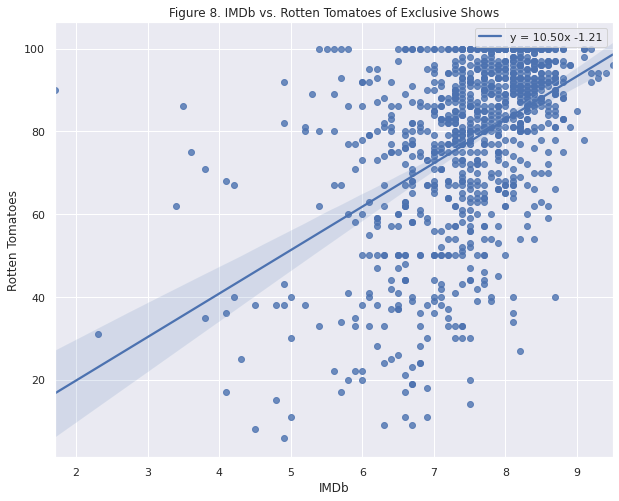

In [19]:
lm = LinearRegression()
lm.fit(df2[["IMDb"]], df2["Rotten Tomatoes"])

sns.set(rc={"figure.figsize":(10, 8)})
ax = sns.regplot(x = "IMDb", y = "Rotten Tomatoes", data = df2, 
                 line_kws={"label":"y = {0:.2f}x {1:.2f}".format(lm.coef_[0],lm.intercept_)})
ax.legend()
ax.set(title = "Figure 8. IMDb vs. Rotten Tomatoes of Exclusive Shows")
plt.show()

The regression plot of exclusive shows is similar to all shows, with a 0.02 reduction in slope and 0.17 increase in y-intercept. There is a positive correlation, but not a strong one.

<h1>4. Conclusion</h1>

We examined four streaming platforms, and found that Netflix has the most number of exclusive shows with 421, and Disney+ has the least with 21. For the average IMDb ratings, Prime Video is the highest with 7.6, and Disney+ with the lowest with 7.3. However, for the average Rotten Tomatoes ratings, Disney+ is the highest with 79.9, and Prime Video is the lowest with 76.3. For quantity, subscribing to Netflix will allow us to get access to the most number of exclusive shows. As for quality, there is no clear winner. Rather, we should make our decision by looking at specific exclusive titles we are interested in since the variances in average ratings are small.

We also looked at the correlation between IMDb and Rotten Tomatoes ratings of all shows and just exclusive shows. The results were similar, both demonstrating positive correlations, thou they are not strong. From the regression plots, we can see that there are many dots on either side of the regression line. This implied that both sites have a number of reviews with different conclusions and they are not saying the same things about the shows. It should still be a good idea to give both sites a visit when looking for reviews.